In [1]:
import pandas as pd

# STEP 1: Load only the necessary columns from the dataset
events = pd.read_csv("events.csv", usecols=['timestamp', 'visitorid', 'event', 'itemid'])

# STEP 2: Convert timestamp from milliseconds to readable datetime
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')

# STEP 3: Filter only 'transaction' events (purchases)
transactions = events[events['event'] == 'transaction'].copy()

# STEP 4: Drop the 'event' column (we no longer need it)
transactions.drop('event', axis=1, inplace=True)

# STEP 5: Rename columns for clarity
transactions.columns = ['timestamp', 'user_id', 'item_id']

# STEP 6: Group by date and item to count daily sales
transactions['date'] = transactions['timestamp'].dt.date
daily_sales = transactions.groupby(['date', 'item_id']).size().reset_index(name='sales_count')

# Preview the result
print(daily_sales.head())


         date  item_id  sales_count
0  2015-05-03      829            1
1  2015-05-03     4001            1
2  2015-05-03    12404            1
3  2015-05-03    14680            1
4  2015-05-03    29877            1


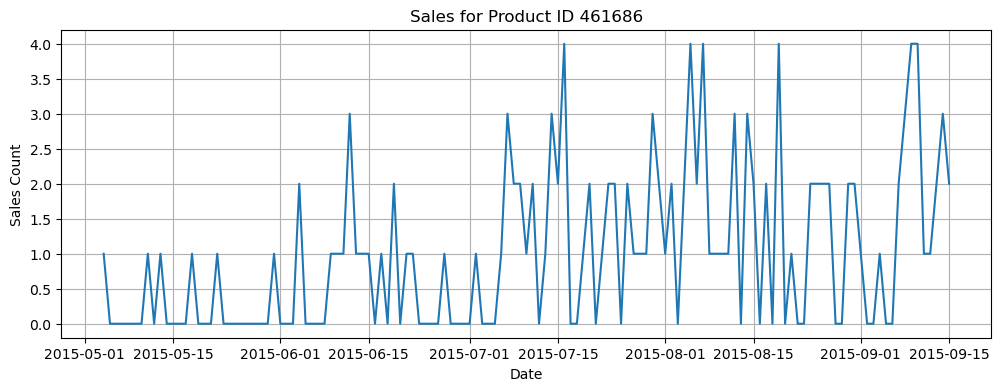

In [2]:
import matplotlib.pyplot as plt

# STEP 1: Find top selling product
top_product = daily_sales['item_id'].value_counts().idxmax()

# STEP 2: Filter sales for that product
product_sales = daily_sales[daily_sales['item_id'] == top_product]

# STEP 3: Ensure dates are sorted and complete (fill missing days with 0)
product_sales = product_sales.set_index('date').asfreq('D', fill_value=0)
product_sales = product_sales.sort_index()

# Final time series
ts = product_sales['sales_count']

# STEP 4: Visualize the product's sales history
plt.figure(figsize=(12,4))
plt.plot(ts)
plt.title(f"Sales for Product ID {top_product}")
plt.xlabel("Date")
plt.ylabel("Sales Count")
plt.grid(True)
plt.show()


In [3]:
# Step-by-Step Code for Preparing LSTM Input

import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Step 1: Reshape data for scaling
values = ts.values.reshape(-1, 1)

# Step 2: Normalize using MinMaxScaler
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values)

# Step 3: Create sequences (sliding window)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 14  # using past 14 days to predict the next day
X, y = create_sequences(scaled_values, window_size)

# Step 4: Train-test split (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Step 5: Reshape for LSTM input [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (96, 14, 1)
X_test shape: (25, 14, 1)


In [4]:
#Train an LSTM model on your sales sequence and learn how it behaves over time to predict future demand.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Build the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

# Step 2: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 3: Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


C:\Users\sriks\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - loss: 0.1267 - val_loss: 0.1692
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0822 - val_loss: 0.1158
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0729 - val_loss: 0.0976
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0794 - val_loss: 0.0999
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0660 - val_loss: 0.1120
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0629 - val_loss: 0.1137
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0725 - val_loss: 0.1053
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0589 - val_loss: 0.1016


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


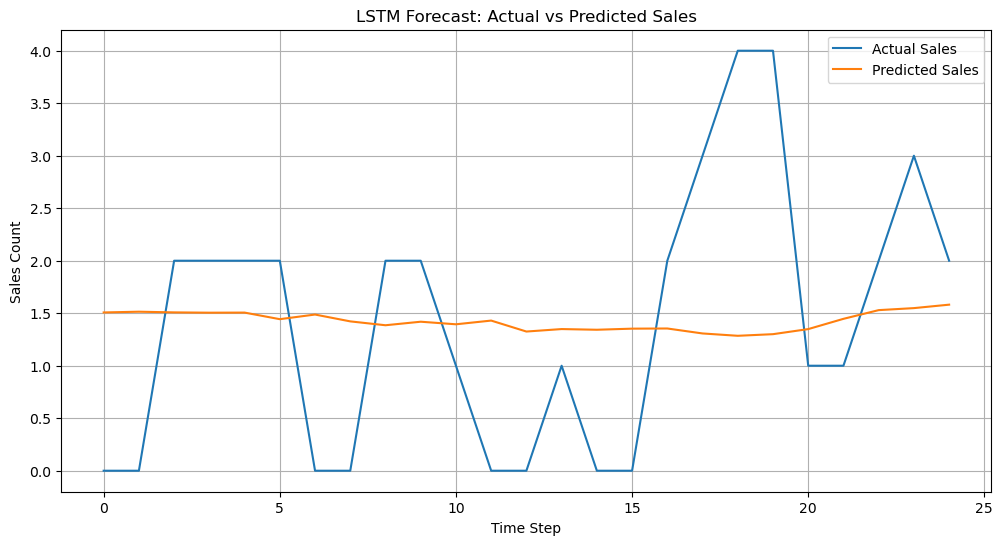

In [5]:
#Predict & Plot Forecasted Sales
#Use the trained LSTM to predict test data and plot actual vs predicted sales.
import matplotlib.pyplot as plt

# Step 1: Predict on test set
y_pred = model.predict(X_test)

# Step 2: Inverse transform to get real sales values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 3: Plot Actual vs Predicted Sales
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Sales')
plt.plot(y_pred_inv, label='Predicted Sales')
plt.title('LSTM Forecast: Actual vs Predicted Sales')
plt.xlabel('Time Step')
plt.ylabel('Sales Count')
plt.legend()
plt.grid(True)
plt.show()



In [8]:
#redict the next 7 sales counts using the last known data from your model.

# Start with last known window from the test set
future_input = X_test[-1].reshape(1, 14, 1)

# Store predictions here
future_predictions = []

for _ in range(7):
    # Predict the next value
    next_pred = model.predict(future_input)[0][0]
    
    # Save prediction
    future_predictions.append(next_pred)
    
    # Update the window: remove oldest, add newest
    new_window = np.append(future_input[0][1:], [[next_pred]], axis=0)
    future_input = new_window.reshape(1, 14, 1)

# Inverse scale predictions to get actual values
future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Show results
for i, val in enumerate(future_predictions_inv, 1):
    print(f"Day +{i}: Predicted sales = {val[0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Day +1: Predicted sales = 1.58
Day +2: Predicted sales = 1.64
Day +3: Predicted sales = 1.71
Day +4: Predicted sales = 1.77
Day +5: Predicted sales = 1.80
Day +6: Predicted sales = 1.85
Day +7: Predicted sales = 1.90


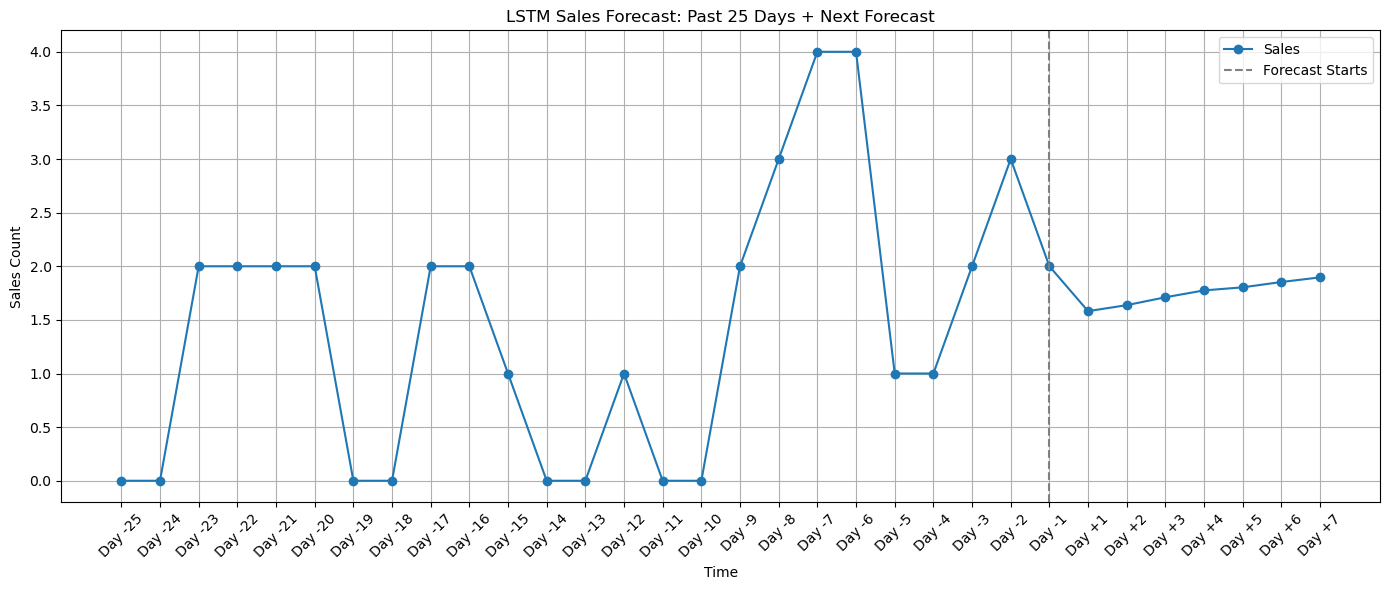

In [14]:
#Plotting: Actual vs Future Forecast (Next 14 Days)
import matplotlib.pyplot as plt
import numpy as np

# 1. Get last 25 actual sales
recent_actual = scaler.inverse_transform(y_test.reshape(-1, 1))[-25:]

# 2. Combine with future predictions (make sure future_predictions_inv is correct shape)
combined = np.concatenate([recent_actual, future_predictions_inv])

# 3. Build timeline dynamically
num_actual = recent_actual.shape[0]
num_future = future_predictions_inv.shape[0]
total_days = num_actual + num_future

days = [f'Day -{num_actual - i}' for i in range(num_actual)] + [f'Day +{i+1}' for i in range(num_future)]

# 4. Plot
plt.figure(figsize=(14, 6))
plt.plot(range(total_days), combined.flatten(), marker='o', label='Sales')  # <- .flatten() added
plt.axvline(x=num_actual - 1, linestyle='--', color='gray', label='Forecast Starts')
plt.xticks(ticks=range(total_days), labels=days, rotation=45)
plt.title("LSTM Sales Forecast: Past 25 Days + Next Forecast")
plt.xlabel("Time")
plt.ylabel("Sales Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()






In [16]:
#User-Based Recommendations
#Recommend top products to a customer based on what they’ve previously interacted with (clicked, carted, or purchased).

# Load and Filter Events Data
import pandas as pd

# Load only what we need
events = pd.read_csv("events.csv", usecols=['timestamp', 'visitorid', 'event', 'itemid'])

# Focus on 'view', 'addtocart', and 'transaction'
events = events[events['event'].isin(['view', 'addtocart', 'transaction'])]

# Rename for clarity
events.columns = ['timestamp', 'user_id', 'action', 'item_id']

# Show preview
events.head()


,timestamp,user_id,action,item_id
0,1433221332117,257597,view,355908
1,1433224214164,992329,view,248676
2,1433221999827,111016,view,318965
3,1433221955914,483717,view,253185
4,1433221337106,951259,view,367447


In [18]:
#Get Top Products per User
# Assign weights to event types
events['weight'] = events['action'].map({
    'view': 1,
    'addtocart': 2,
    'transaction': 3
})

# Group by user and item and sum interaction weights
user_item_scores = events.groupby(['user_id', 'item_id'])['weight'].sum().reset_index()

# Sort top items per user
user_item_scores = user_item_scores.sort_values(['user_id', 'weight'], ascending=[True, False])

# Updated function to recommend top items
def recommend_top_items(user_id, top_n=5):
    user_data = user_item_scores[user_item_scores['user_id'] == user_id]
    return user_data.head(top_n)['item_id'].tolist()



In [20]:
#Show Product Details (Enhance Recommendations)
# Load item properties (just once)
# Load the item properties CSV
item_props = pd.read_csv("item_properties_part1.csv")

# Optional: Preview to confirm it's working
print(item_props.head())

# Also recheck the available property types (e.g., 'categoryid')
print(item_props['property'].unique())



       timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014         400  n552.000 639502 n720.000 424566
3  1431226800000   59481         790                       n15360.000
4  1431831600000  156781         917                           828513
['categoryid' '888' '400' ... '424' '494' '712']


In [22]:
# Try filtering a valid property you found in the list
item_names = item_props[item_props['property'] == 'categoryid']

# Check if your recommended item IDs are present
sample_user = user_item_scores['user_id'].iloc[0]
recommended_ids = recommend_top_items(sample_user)
recommended_df = item_names[item_names['itemid'].isin(recommended_ids)]

# Show results
recommended_df.head()


,timestamp,itemid,property,value
4380743,1432436400000,67045,categoryid,333
9131305,1431226800000,357564,categoryid,256


In [24]:
# STEP 1: Pick a user from the weighted interaction list
sample_user = user_item_scores['user_id'].iloc[0]

# STEP 2: Get top 5 item IDs recommended for this user
recommended_ids = recommend_top_items(sample_user)

# STEP 3: Load item properties if not already loaded
item_props = pd.read_csv("item_properties_part1.csv")
item_names = item_props[item_props['property'] == 'categoryid']

# STEP 4: Filter category information for recommended items
recommended_df = item_names[item_names['itemid'].isin(recommended_ids)]
recommended_df = recommended_df[['itemid', 'value']].drop_duplicates()
recommended_df.columns = ['Item ID', 'Category ID']

# STEP 5: Get score info from user_item_scores for these items
top_items = user_item_scores[user_item_scores['user_id'] == sample_user]
final = pd.merge(recommended_df, top_items, left_on='Item ID', right_on='item_id')[['Item ID', 'Category ID', 'weight']]
final = final.rename(columns={'weight': 'Score'})

# STEP 6: Sort and display
final = final.sort_values('Score', ascending=False).reset_index(drop=True)
final



,Item ID,Category ID,Score
0,67045,333,1
1,357564,256,1


In [26]:
final.to_csv("recs.csv", index=False)
print("✅ recs.csv saved successfully!")




✅ recs.csv saved successfully!


In [28]:
# Generate 14-Day Forecast
import numpy as np

# Start with the last input window from test set
future_input = X_test[-1].reshape(1, window_size, 1)
future_predictions = []

# Generate next 14 days
for _ in range(14):
    next_pred = model.predict(future_input)[0][0]
    future_predictions.append(next_pred)
    
    new_window = np.append(future_input[0][1:], [[next_pred]], axis=0)
    future_input = new_window.reshape(1, window_size, 1)

# Inverse transform predictions
future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [30]:
import pandas as pd

forecast_df = pd.DataFrame(future_predictions_inv, columns=['Predicted_Sales'])
forecast_df.to_csv("forecast.csv", index=False)
print("forecast.csv saved successfully!")


forecast.csv saved successfully!
